# Problema de las $N$ reinas.
### Autor: Saúl Sosa Díaz



---
## El Problema.
El rompecabezas de las $N$ reinas es el problema de colocar $N$ reinas de ajedrez en un tablero de ajedrez de $N$×$N$ de manera que ninguna reina amenace a otra. Por lo tanto, una solución requiere que ninguna reina comparta la misma fila, columna o diagonal. Existen soluciones para todos los números naturales $\N$ con la excepción de $n = 2$ y $n = 3$ $\forall n \in \N$. 
Aunque el número exacto de soluciones sólo se conoce para $n ≤ 27$, la tasa de crecimiento asintótico del número de soluciones es aproximadamente $(0.143 n)n$.
  
El problema original se planteó para un tablero de ajedrez convencional de $8$ × $8$. Existen 92 soluciones posibles para esta variante, teniendo en cuenta las rotaciones. Sin considerar dichas rotaciones, hay 12 soluciones únicas. Esta cuestión fue propuesta por primera vez a mediados del siglo XIX. En tiempos contemporáneos, frecuentemente se presenta como un ejemplo para ilustrar diversas técnicas de programación.

En este cuaderno, exploraremos múltiples métodos para resolver el problema, incluyendo la creación de diversos modelos matemáticos. Estos modelos serán procesados por un software de resolución, como por ejemplo, GLPK.


#### Definiendo un Modelo Inicial
Considerando un tablero de ajedrez de tamaño N, el enfoque inicial para resolver el problema podría modelarse de la siguiente manera:

##### Variables
$\text{Donde }x_{ij} = \begin{dcases}
   1 &\text{Si hay una reina en la posición } (i,j). \\
   0 &\text{Otro caso}.
\end{dcases} \text{ }\forall i \in \{ 1 \dots n\} \land \forall j \in \{ 1 \dots n\}$
##### Función objetivo
Este problema se distingue de los abordados anteriormente en la asignatura, debido a su naturaleza de factibilidad. En este caso, no se requiere una función objetivo para su resolución.

##### Restricciones
$$
    \begin{array}{ccc} & 
    \\ \sum_{j} x_{ij} = 1 \quad \forall i \in \{ 1 \dots n\}   \quad \text{En cada fila solo una reina.}
    \\ \sum_{i} x_{ij} = 1 \quad \forall j \in \{ 1 \dots n\}  \quad \text{En cada columna solo una reina.}
    \\ \sum_{k} \sum_{l} x_{k,l} \leq 1 \quad \text{si } k - l = i - j, \; \forall i, j \in \{1, 2, ..., n\}  \quad \text{En cada diagonal descendente a lo sumo puede haber una reina.}
    \\ \sum_{k} \sum_{l} x_{k,l} \leq 1 \quad \text{si } k + l = i + j, \; \forall i, j \in \{1, 2, ..., n\} \quad \text{En cada diagonal ascendente a lo sumo puede haber una reina.}
    \end{array}
$$

Ahora procederemos a implementar la codificación del modelo utilizando GLPK.

In [15]:
using JuMP, GLPK

function first_model_nqueens(n)
    model = Model(GLPK.Optimizer)
    
    # Decision variables
    @variable(model, x[1:n, 1:n], Bin)
    number_of_constraints = 0
    # Row and column restrictions
    for i in 1:n
        @constraint(model, sum(x[i, j] for j in 1:n) == 1)  # One queen per row
        @constraint(model, sum(x[j, i] for j in 1:n) == 1)  # One queen per column
        number_of_constraints += 2
    end
    
    # Diagonal restrictions
    for i in 1:n
        for j in 1:n
            # Each descending diagonal can have at most one queen
            @constraint(model, sum(x[k, l] for k in 1:n, l in 1:n if k-l == i-j) <= 1) # k - l = i - j means that they are in the same right ascending line e.g. (1,1) 1 - 1 = 0 and 2 - 2 = 0 
            # Each ascending diagonal can have at most one queen.
            @constraint(model, sum(x[k, l] for k in 1:n, l in 1:n if k+l == i+j) <= 1)
            number_of_constraints += 2
        end
    end
    
    # Solve the model
    optimize!(model)
    return value.(x), solve_time(model), number_of_constraints
end

first_model_nqueens (generic function with 1 method)

En la celda siguiente, desarrollaremos una función cuyo objetivo es presentar la solución de forma intuitiva y fácil de entender.

In [16]:
using Plots

function plot_nqueens(solution)
    n = size(solution, 1)
    p = plot(; 
            legend=false, 
            ratio=1, 
            xlims=(0, n), 
            ylims=(0, n), 
            xticks=1:n, 
            yticks=1:n, 
            border=:none,   
            background_color_inside=:lightgray, 
            background_color_outside=:transparent, 
            grid=false
            )
    
    # Draw the board
    for i in 1:n
        for j in 1:n
            if (i + j) % 2 == 0
                plot!([j-1, j, j, j-1, j-1], [n-i, n-i, n-i+1, n-i+1, n-i], fill=(0, :lightgray), linealpha=0)
            else
                plot!([j-1, j, j, j-1, j-1], [n-i, n-i, n-i+1, n-i+1, n-i], fill=(0, :darkgray), linealpha=0)
            end
        end
    end

    pastel_blue = RGB(0.6, 0.8, 0.9)
    marker_diameter = 1.0/n * 100  # This adjusts the size of the marker based on the number of squares.
    # Place the queens
    for i in 1:n
        for j in 1:n
            if solution[i, j] == 1
                scatter!([j-0.5], [n-i+0.5], markercolor=pastel_blue, markershape=:circle, markerstrokewidth=1, markersize=marker_diameter, label=false)
            end
        end
    end
    display(p)
end

plot_nqueens (generic function with 1 method)

Resolveremos y presentaremos la solución del problema para valores de $n$ que van desde 6 hasta 8.

Solution for 6 queens: 


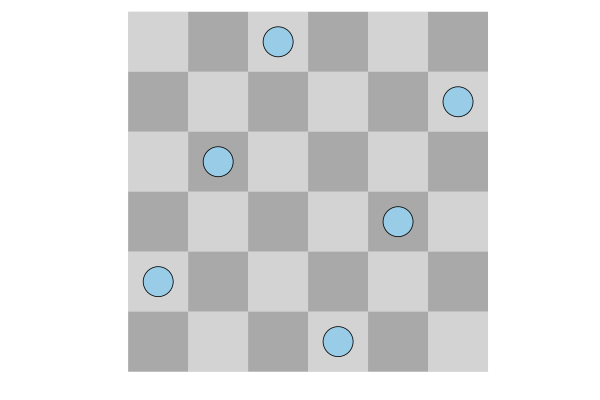

Solution for 7 queens: 


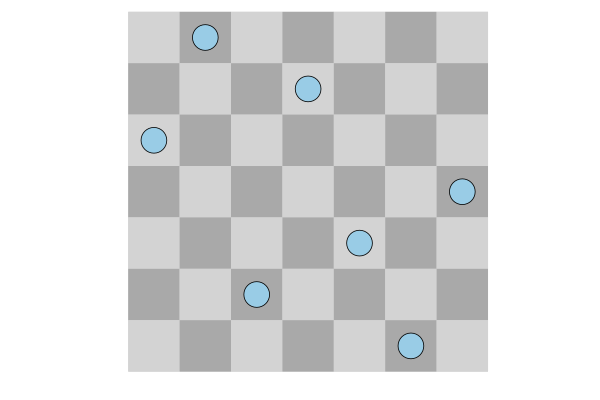

Solution for 8 queens: 


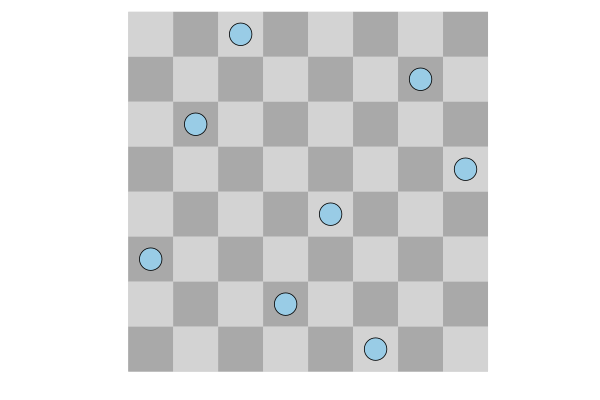

In [17]:
for n in 6:8
    result, time, nconstraints = first_model_nqueens(n)
    println("Solution for $n queens: ")
    plot_nqueens(result)
end

A continuación, introduciremos un segundo modelo para abordar el problema.

##### Variables
$\text{Donde }x_{ij} = \begin{dcases}
   1 &\text{Si hay una reina en la posición } (i,j). \\
   0 &\text{Otro caso}.
\end{dcases} \text{ }\forall i \in \{ 1 \dots n\} \land \forall j \in \{ 1 \dots n\}$
##### Función objetivo
Este modelo aborda el mismo problema y, al igual que el anterior, no necesita de una función objetivo para su resolución.

##### Restricciones
$$
    \begin{array}{ccc} & 
    \\ \sum_{i} x_{ij} = 1 \quad \forall i \in \{ 1 \dots n\}   \quad \text{En cada fila solo una reina.}
    \\ \sum_{j} x_{ij} = 1 \quad \forall j \in \{ 1 \dots n\}  \quad \text{En cada columna solo una reina.}
    \\ \sum_{i} \sum_{j} x_{i,j} \leq 1 \quad \text{si } i + j = d, \; \forall d \in \{2, 3, ..., 2n\} \quad \text{En cada diagonal ascendente a lo sumo puede haber una reina.}
    \\ \sum_{i=1}^{n} \sum_{j=1}^{n} x_{i,j} \leq 1 \quad \text{si } i - j = d, \; \forall d \in \{1-n, 1-n+1, ..., n-1\} \quad \text{En cada diagonal descendente a lo sumo puede haber una reina.}
    \end{array}
$$

Es crucial destacar en este modelo las restricciones asociadas con la variable auxiliar $d$, la cual representa el índice de la diagonal. Las diagonales se identifican de manera única mediante la suma o la diferencia de las coordenadas de sus celdas. La estrategia consiste en enumerar las diagonales a través de estas operaciones matemáticas.

* Para las diagonales descendentes, que van de la esquina superior izquierda a la esquina inferior derecha, empleamos la suma $i + j$. En este escenario, $d$ varía entre $2$ y $2n$.

- En el caso de las diagonales ascendentes, que se extienden desde la esquina inferior izquierda hasta la esquina superior derecha, usamos la diferencia $i - j$. Aquí, $d$ puede asumir valores en el rango de  $1-n$ a  $n-1$.

Ahora lo codificamos.


In [18]:
function second_model_nqueens(n)
    model = Model(GLPK.Optimizer)
    
    # Decision variables
    @variable(model, x[1:n, 1:n], Bin)

    number_of_constraints = 0

    # One queen per row
    for i in 1:n
        @constraint(model, sum(x[i, j] for j in 1:n) == 1)
        number_of_constraints += 1
    end

    # One queen per column
    for j in 1:n
        @constraint(model, sum(x[i, j] for i in 1:n) == 1)
        number_of_constraints += 1
    end

    # Only one queen per ascending diagonal
    for d in 2:2n
        @constraint(model, sum(x[i, j] for i in 1:n for j in 1:n if i + j == d) <= 1)
        number_of_constraints += 1
    end

    # Only one queen per descending diagonal
    for d in 1-n:n-1
        @constraint(model, sum(x[i, j] for i in 1:n for j in 1:n if i - j == d) <= 1)
        number_of_constraints += 1
    end

    # solve the model
    optimize!(model)

    return value.(x), solve_time(model), number_of_constraints
end

second_model_nqueens (generic function with 1 method)

Comprobamos los resultados utilizando los mismos valores de entrada que en el ejemplo anterior.

Solution for 6 queens: 


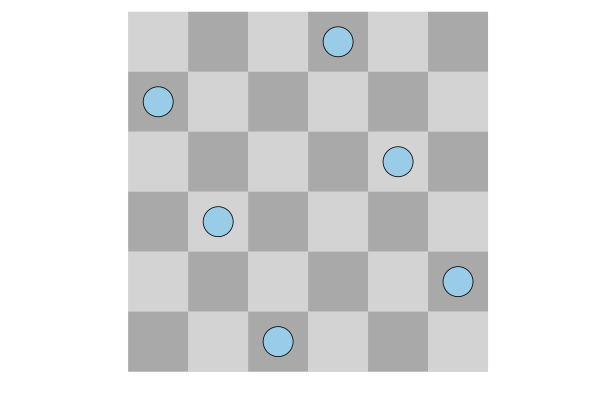

Solution for 7 queens: 


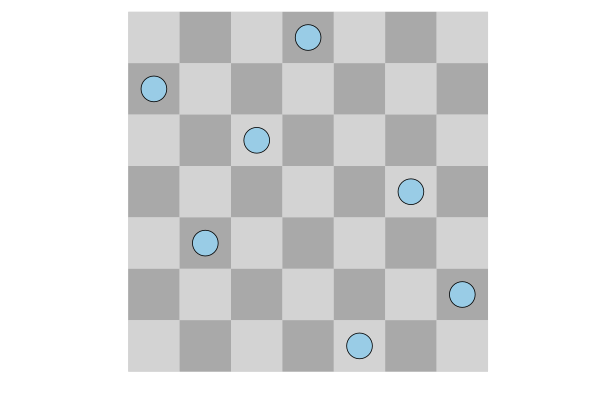

Solution for 8 queens: 


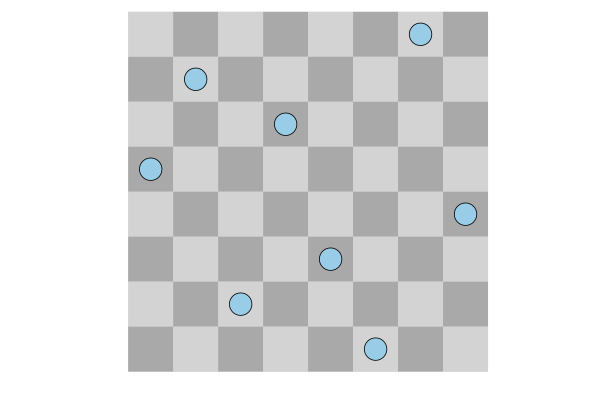

In [19]:
for n in 6:8
    result, time, nconstraints = second_model_nqueens(n)
    println("Solution for $n queens: ")
    plot_nqueens(result)
end

#### Comparación de modelos
A continuación, realizaremos una comparativa entre los dos modelos para determinar cuál es más eficiente.

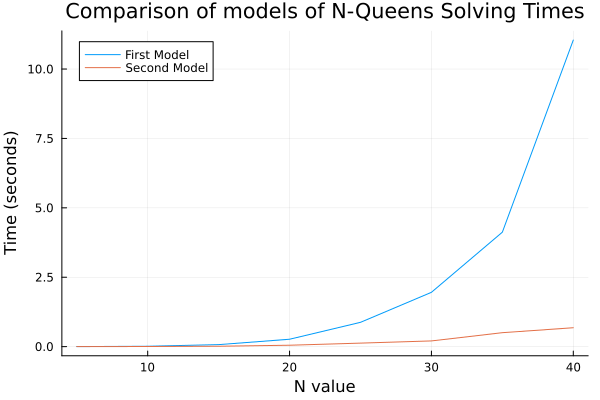

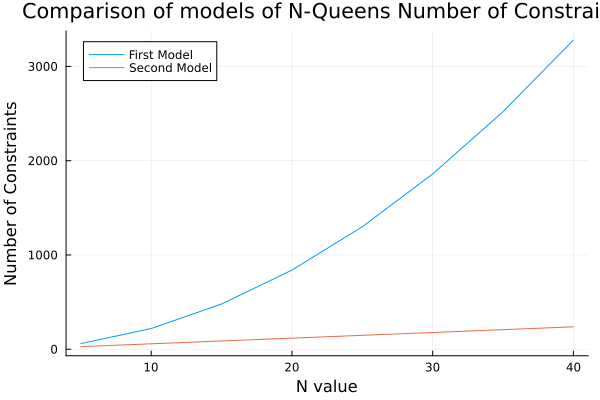

In [20]:
timesFirstModel = []
timesSecondModel = []
number_of_constraintsFirstModel = []
number_of_constraintsSecondModel = []
max_n = 40
for n in 5:5:max_n # Generates an array of 5 to 40 in 5 by 5
    result, time, number_of_constraint = first_model_nqueens(n)
    push!(timesFirstModel, time)
    push!(number_of_constraintsFirstModel, number_of_constraint)
    result, time, number_of_constraint = second_model_nqueens(n)
    push!(timesSecondModel, time)
    push!(number_of_constraintsSecondModel, number_of_constraint)
end



# Create the plot
n_values = 5:5:max_n
plt = plot(n_values, timesFirstModel, label="First Model", line=:solid, xlabel="N value", ylabel="Time (seconds)", title="Comparison of models of N-Queens Solving Times")
plot!(n_values, timesSecondModel, label="Second Model", line=:solid)
#Show the plot
display(plt)

# Create the plot
plt2 = plot(n_values, number_of_constraintsFirstModel, label="First Model", line=:solid, xlabel="N value", ylabel="Number of Constraints", title="Comparison of models of N-Queens Number of Constraints")
plot!(n_values, number_of_constraintsSecondModel, label="Second Model", line=:solid)

#Show the plot
display(plt2)

Podemos observar que el tiempo de ejecución del primer modelo aumenta significativamente en comparación con el segundo modelo. Esta diferencia proporciona evidencia de que el segundo modelo es más eficiente, especialmente para valores mayores de $N$, donde su tiempo de procesamiento es considerablemente menor.

#### Conclusiones
Las diferencias clave entre ambos modelos del problema se centran en cómo se formulan las restricciones diagonales. En el primer modelo, cada celda $(i, j)$ del tablero impone una restricción tanto en las diagonales ascendentes como en las descendentes. Este enfoque conlleva un exceso de restricciones redundantes, dado que cada diagonal recibe atención múltiple.

Contrastando esto, el segundo modelo presenta una solución más eficiente y directa. Aquí, se establece una única restricción para cada diagonal, ya sea ascendente o descendente.

Como resultado, el segundo modelo demuestra ser superior. Aunque ambos enfoques logran resolver el problema, el segundo lo hace de manera más ágil y con un menor uso de recursos de memoria. Esta eficiencia le permite manejar problemas de mayor envergadura en un tiempo reducido.